# Classifying Audio

### Setup

- First, run the following cell to import dependencies and define some functions.
- To run a cell in Jupyter, click the cell to highlight it, then press the "play" button in the toolbar above (or press shift+return).

In [1]:
import os
import subprocess
import array
import random
import pandas as pd
from pyAudioAnalysis import audioSegmentation as aS
from itertools import groupby
from operator import itemgetter
from IPython.display import display, Audio
from pydub import AudioSegment
from pydub.utils import get_array_type
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
%matplotlib inline


# Takes list of 1-second segments classified as applause (1.0) or 
# non-applause (0.0) and returns list of 2-tuples specifying applause ranges.
# Add 1 to 2nd value in each 2-tuple for inclusive time span.
def seconds_list_to_ranges(seconds_list): 
    ranges = []                
    for k, g in groupby(enumerate(seconds_list), lambda (i,x):i-x):
        group = map(itemgetter(1), g)
        ranges.append((group[0], group[-1]))
    return ranges


# Displays specified audio segment in Jupyter window using IPython.display
def display_clip(wav_path,start_time,end_time):
    track_data = AudioSegment.from_wav(file=wav_path)
    track_data = track_data.set_channels(1)
    bit_depth = track_data.sample_width * 8
    clip_data = track_data[int(1000*start_time):int(1000*end_time)]
    array_type = get_array_type(bit_depth)
    numeric_array = array.array(array_type, clip_data._data)
    display(Audio(numeric_array, rate=track_data.frame_rate))


# Classifies audio at 1-second resolution, plots results if applause found, 
# and returns applause ranges as list of 2-tuples.
# Add 1 to 2nd value in each 2-tuple for inclusive time span.
def classify(audio_path):
    classifier_model_path = "model/svm_chimes" ### Or replace with another scikit-learn model ###
    is_mp3=False
    if (((audio_path.lower()[:8]=='https://') | (audio_path.lower()[:7]=='http://')) & (audio_path.lower()[-4:]=='.mp3')):
        is_mp3=True
        random.seed(audio_path)
        wav_path='/var/tmp/'+str(random.random())+'_temp.wav'
        mp3_path='/var/tmp/'+str(random.random())+'_temp.mp3' # Filename for temp WAV is a random float
        response = requests.get(audio_path, stream=True)
        with open(mp3_path, "wb") as fo:
            for data in tqdm(response.iter_content()):
                fo.write(data)
        subprocess.call(['ffmpeg', '-y', '-i', mp3_path, wav_path]) # '-y' option overwrites existing file if present

    elif audio_path.lower()[-4:]=='.mp3':    # Creates a temporary WAV
        is_mp3=True                          # if input is MP3
        random.seed(audio_path)
        wav_path='/var/tmp/'+str(random.random())+'_temp.wav' # Filename for temp WAV is a random float
        subprocess.call(['ffmpeg', '-y', '-i', audio_path, wav_path]) # '-y' option overwrites existing file if present
    else:
        wav_path=audio_path
    output, classesAll, acc, CM = aS.mtFileClassification(wav_path, classifier_model_path, "svm")
    output = list(output)
    counter=0
    applause_secs=[]
    for value in output:
        if value>0.0:
            applause_secs.append(counter)
        counter+=1
    applause_ranges=seconds_list_to_ranges(applause_secs)
    if len(applause_ranges)>0:
        print applause_ranges
        print '\n'
        pd.Series(output).plot()
        plt.show()
    for pair in applause_ranges:
        print pair
        try:
            display_clip(wav_path,pair[0],pair[1]+1)
        except: pass
    if is_mp3==True:
        os.remove(wav_path)
    
    return applause_ranges

### Running the Classifier

- Download an NBC recording from [Archive.org](https://archive.org/details/NBCCompleteBroadcastDDay/) that was not included in your training set.

- In the Finder, right-click the audio file while pressing option, then select "Copy [filename.mp3] as Pathname."

- Paste the pathname into the cell below, replacing the example value. 

- Run the cell. The process might take two or three minutes to complete.

[(0, 0), (247, 248), (303, 305), (750, 751), (859, 860), (1602, 1603), (1816, 1816)]




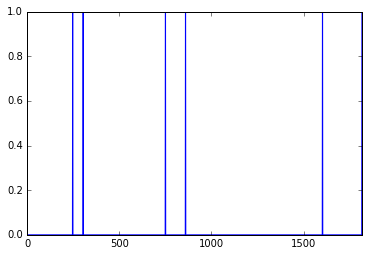

(0, 0)


(247, 248)


(303, 305)


(750, 751)


(859, 860)


(1602, 1603)


(1816, 1816)


[(0, 0),
 (247, 248),
 (303, 305),
 (750, 751),
 (859, 860),
 (1602, 1603),
 (1816, 1816)]

In [2]:
audio_path="/Users/mclaugh/Downloads/CBD-440607_NBC0600-NewsandMusic.mp3"

classify(audio_path)